In [1]:
import pandas as pd
import os
transaction = pd.read_csv('C:\\Users\\HP ZBook 15\\.cache\\kagglehub\\datasets\\frtgnn\\dunnhumby-the-complete-journey\\versions\\1\\transaction_data.csv')
transaction.head(5)
pd.set_option('display.max_rows', None)
product=pd.read_csv('C:\\Users\\HP ZBook 15\\.cache\\kagglehub\\datasets\\frtgnn\\dunnhumby-the-complete-journey\\versions\\1\\product.csv')

In [2]:
# Tiền xử lý dữ liệu để thiết kế state cho Q-Learning

import numpy as np
import pandas as pd
from collections import defaultdict
import random
import time
import matplotlib.pyplot as plt

# Gom nhu cầu theo tuần cho từng sản phẩm
weekly_demand = (
    transaction.groupby(["PRODUCT_ID", "WEEK_NO"])["QUANTITY"]
    .sum()
    .reset_index()
    .rename(columns={"QUANTITY": "WEEKLY_DEMAND"})
)

# Lấy top 5 sản phẩm bán chạy nhất (theo tổng nhu cầu)
top_products = (
    weekly_demand.groupby("PRODUCT_ID")["WEEKLY_DEMAND"]
    .sum()
    .sort_values(ascending=False)
    .head(100)
    .index
)

# Lọc dữ liệu cho top 5 sản phẩm
top_weekly_demand = weekly_demand[weekly_demand["PRODUCT_ID"].isin(top_products)].copy()

# Tính nhu cầu gần đây (moving average trong 3 tuần)
top_weekly_demand["RECENT_DEMAND"] = (
    top_weekly_demand.groupby("PRODUCT_ID")["WEEKLY_DEMAND"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

# Giả định tồn kho ban đầu (ví dụ: 1000 đơn vị cho mỗi sản phẩm)
# và tồn kho tuần = tồn kho tuần trước + nhập hàng (action, chưa có ở đây) - nhu cầu tuần
# Tạm thời mô phỏng tồn kho chỉ bằng cách giảm dần theo nhu cầu (chưa có action nhập hàng)
initial_inventory = 500000
top_weekly_demand["INVENTORY_LEVEL"] = (
    top_weekly_demand.groupby("PRODUCT_ID")["WEEKLY_DEMAND"]
    .cumsum()
    .rsub(initial_inventory)
    .clip(lower=0)
)
# Gom nhu cầu theo tuần cho từng sản phẩm
weekly = (
    transaction.groupby(["PRODUCT_ID", "WEEK_NO"])["QUANTITY"]
    .sum()
    .reset_index()
    .rename(columns={"QUANTITY": "WEEKLY_DEMAND"})
)
# Tính tổng nhu cầu theo sản phẩm, lấy top1 product làm ví dụ
top_products = weekly.groupby("PRODUCT_ID")["WEEKLY_DEMAND"].sum().sort_values(ascending=False)
top_product_id = top_products.index[0]
print(f"Top product id: {top_product_id}, total demand={top_products.iloc[0]}")

prod_df = weekly[weekly["PRODUCT_ID"] == top_product_id].sort_values("WEEK_NO").reset_index(drop=True)

# Nếu thiếu tuần nào, reindex tuần 1..max_week để có chuỗi đầy đủ
max_week = prod_df["WEEK_NO"].max()
all_weeks = pd.DataFrame({"WEEK_NO": range(1, max_week+1)})
prod_df = all_weeks.merge(prod_df, on="WEEK_NO", how="left").fillna({"PRODUCT_ID": top_product_id, "WEEKLY_DEMAND": 0})

# Tính recent demand: moving average 3 tuần (dịch sang quá khứ để causal)
prod_df["RECENT_DEMAND"] = prod_df["WEEKLY_DEMAND"].rolling(window=3, min_periods=1).mean().shift(1).fillna(method="bfill")

print(prod_df.head(10))




Top product id: 6534178, total demand=216532156
   WEEK_NO  PRODUCT_ID  WEEKLY_DEMAND  RECENT_DEMAND
0        1   6534178.0            0.0       0.000000
1        2   6534178.0         2456.0       0.000000
2        3   6534178.0        51596.0    1228.000000
3        4   6534178.0        47140.0   18017.333333
4        5   6534178.0        72836.0   33730.666667
5        6   6534178.0        79716.0   57190.666667
6        7   6534178.0       247432.0   66564.000000
7        8   6534178.0       467412.0  133328.000000
8        9   6534178.0       660494.0  264853.333333
9       10   6534178.0       853438.0  458446.000000


C:\Users\HP ZBook 15\AppData\Local\Temp\ipykernel_36004\1089661231.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prod_df["RECENT_DEMAND"] = prod_df["WEEKLY_DEMAND"].rolling(window=3, min_periods=1).mean().shift(1).fillna(method="bfill")


In [3]:
# --------- 2) Định nghĩa environment InventoryEnv ----------
class InventoryEnv:
    def __init__(self, demand_series, recent_demand_series,
                 action_set=None,
                 initial_inventory=1000,
                 max_inventory=5000,
                 holding_cost=0.01,
                 stockout_cost=1.0,
                 unit_price=1.0,
                 unit_order_cost=0.2,
                 order_fixed_cost=5.0,
                 n_inv_bins=20,
                 n_demand_bins=10):
        self.demand = np.array(demand_series, dtype=float)#Chuỗi nhu cầu thực tế theo tuần
        self.recent = np.array(recent_demand_series, dtype=float)#Nhu cầu gân đây(theo moving average)
        self.T = len(self.demand)
        self.initial_inventory = initial_inventory#Tồn kho ban đầu
        self.max_inventory = max_inventory# Tồn kho tối đa
        self.holding_cost = holding_cost#Chi phí lưu kho
        self.stockout_cost = stockout_cost#Chi phí thiếu hàng
        self.unit_price = unit_price#Giá bán của mỗi sản phẩm
        self.unit_order_cost = unit_order_cost#Chi phí nhập hàng
        self.order_fixed_cost = order_fixed_cost#Chi phí cố định cho mỗi đơn hàng
        
        if action_set is None:
            avg = max(1.0, int(np.ceil(self.recent.mean())))
            action_set = [0, avg, 2*avg, 4*avg, 8*avg]
        self.ACTIONS = sorted(list(set(int(a) for a in action_set)))
        
        self.inv_bins = np.linspace(0, max_inventory, n_inv_bins+1)
        self.dem_bins = np.linspace(0, max(1.0, self.recent.max()), n_demand_bins+1)
        self.week_mod = 52
        
        self.reset()
    
    def reset(self, start_week=0):
        self.week = start_week
        self.inventory = self.initial_inventory
        return self._get_state()
    #Rời rạc hóa state(tồn kho, tuần, nhu cầu gần đây)
    def _discretize(self, inventory, week_idx, recent_demand):
        inv_bucket = int(np.digitize([inventory], self.inv_bins)[0] - 1)#mức tồn kho
        inv_bucket = max(0, min(inv_bucket, len(self.inv_bins)-2))
        dem_bucket = int(np.digitize([recent_demand], self.dem_bins)[0] - 1)#nhu cầu gần đây
        dem_bucket = max(0, min(dem_bucket, len(self.dem_bins)-2))
        week_bucket = int(week_idx % self.week_mod)#Tuần trong năm(0-51)
        return (inv_bucket, week_bucket, dem_bucket)
    
    def _get_state(self):
        return self._discretize(self.inventory, self.week, self.recent[self.week])
    
    def step(self, action_idx):
        #Thực hiên nhập hàng
        order_qty = self.ACTIONS[action_idx]
        demand = self.demand[self.week]
        recent = self.recent[self.week]
        inventory_before_sales = min(self.inventory + order_qty, self.max_inventory)
        #Đáp ứng nhu cầu
        sales = min(inventory_before_sales, demand)
        unmet = max(0.0, demand - inventory_before_sales)
        inventory_next = inventory_before_sales - sales
        #Tính reward
        revenue = sales * self.unit_price
        holding = inventory_next * self.holding_cost
        stockout_penalty = unmet * self.stockout_cost
        order_cost = (self.order_fixed_cost if order_qty > 0 else 0.0) + order_qty * self.unit_order_cost
        
        reward = revenue - holding - stockout_penalty - order_cost
        #Cập nhập lại trạng thái(Tuần và tồn kho)
        self.inventory = inventory_next
        self.week += 1
        done = (self.week >= self.T)
        next_state = self._get_state() if not done else None
        
        info = {"sales": sales, "demand": demand, "unmet": unmet, "order": order_qty,
                "inventory": inventory_next, "revenue": revenue,
                "holding": holding, "order_cost": order_cost}
        return next_state, reward, done, info


In [4]:
import random
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.2, epsilon_decay=0.9995, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(lambda: np.zeros(len(self.env.ACTIONS), dtype=float))
    
    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(len(self.env.ACTIONS))
        qvals = self.Q[state]
        max_indices = np.flatnonzero(qvals == qvals.max())
        return int(np.random.choice(max_indices))
    
    def learn(self, state, action, reward, next_state, done):
        q = self.Q[state][action]
        if done or next_state is None:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state][action] += self.alpha * (target - q)
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
    
    def policy(self, state):
        qvals = self.Q[state]
        return int(np.argmax(qvals))

In [5]:
# --------- 4) Train ----------
env = InventoryEnv(demand_series=prod_df["WEEKLY_DEMAND"].values,
                   recent_demand_series=prod_df["RECENT_DEMAND"].values,
                   initial_inventory=10000,
                   max_inventory=50000,
                   holding_cost=0.02,
                   stockout_cost=2.0,
                   unit_price=1.0,
                   unit_order_cost=0.3,
                   order_fixed_cost=10.0,
                   n_inv_bins=30,
                   n_demand_bins=12)

agent = QLearningAgent(env, alpha=0.1, gamma=0.95, epsilon=0.4, epsilon_decay=0.995, min_epsilon=0.02)

n_episodes = 20000
history = {"episode_reward": [], "episode_sales": [], "epsilon": []}
start_time = time.time()
for ep in range(n_episodes):
    state = env.reset(start_week=0)
    total_reward = 0.0
    total_sales = 0.0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        total_sales += info["sales"]
    history["episode_reward"].append(total_reward)
    history["episode_sales"].append(total_sales)
    history["epsilon"].append(agent.epsilon)
    if (ep+1) % 50 == 0 or ep==0:
        print(f"Episode {ep+1}/{n_episodes}: reward={total_reward:.1f}, sales={total_sales:.1f}, eps={agent.epsilon:.3f}")
print("Training time:", time.time()-start_time)

Episode 1/20000: reward=-623665259.3, sales=3849596.0, eps=0.240
Episode 50/20000: reward=-559203328.6, sales=3500000.0, eps=0.020
Episode 100/20000: reward=-544956458.6, sales=3257140.0, eps=0.020
Episode 150/20000: reward=-570748666.3, sales=3602456.0, eps=0.020
Episode 200/20000: reward=-536727244.7, sales=3297140.0, eps=0.020
Episode 250/20000: reward=-559629338.3, sales=3150000.0, eps=0.020
Episode 300/20000: reward=-550066515.0, sales=4050000.0, eps=0.020
Episode 350/20000: reward=-535446083.8, sales=3100000.0, eps=0.020
Episode 400/20000: reward=-533566184.9, sales=3102456.0, eps=0.020
Episode 450/20000: reward=-547349502.1, sales=3499596.0, eps=0.020
Episode 500/20000: reward=-540289408.2, sales=3149596.0, eps=0.020
Episode 550/20000: reward=-557189434.9, sales=3547140.0, eps=0.020
Episode 600/20000: reward=-525156981.0, sales=3202456.0, eps=0.020
Episode 650/20000: reward=-519076458.0, sales=3149596.0, eps=0.020
Episode 700/20000: reward=-520174288.6, sales=3199596.0, eps=0.02

Eval reward: -433982503.48 sales: 110000.0
last 20 actions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2079701, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


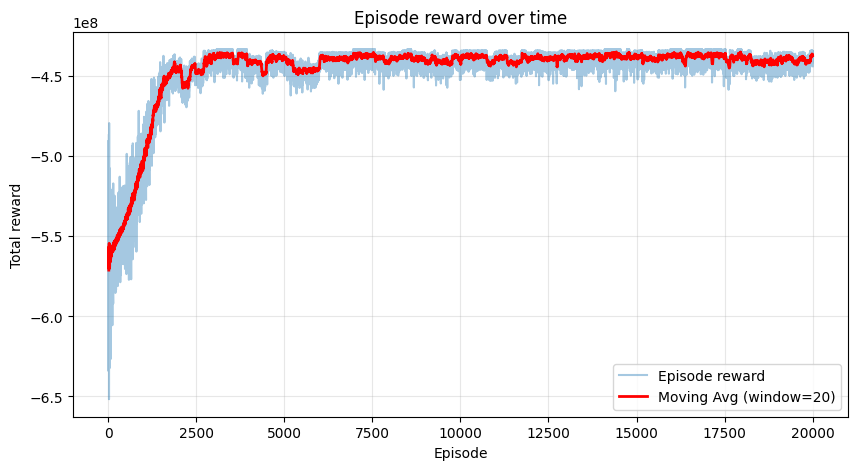

In [7]:
# --------- 5) Evaluate greedy policy ----------
def evaluate(agent, env, start_week=0):
    state = env.reset(start_week=start_week)
    done = False
    total_reward = 0.0
    total_sales = 0.0
    actions = []
    while not done:
        action = agent.policy(state)
        next_state, reward, done, info = env.step(action)
        actions.append(env.ACTIONS[action])
        total_reward += reward
        total_sales += info["sales"]
        state = next_state
    return {"total_reward": total_reward, "total_sales": total_sales, "actions": actions}

res = evaluate(agent, env)
print("Eval reward:", res["total_reward"], "sales:", res["total_sales"])
print("last 20 actions:", res["actions"][:-20])


rewards = np.array(history["episode_reward"])
#Biểu đồ reward theo từng eps biễu diễn sự hội tụ
plt.figure(figsize=(10,5))
plt.plot(rewards, alpha=0.4, label="Episode reward")

window = 20
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode="valid")
    plt.plot(range(window-1, len(rewards)), moving_avg, label=f"Moving Avg (window={window})", linewidth=2, color="red")

plt.title("Episode reward over time")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()